In [1]:
#SO2 segmentation this one will be focused on the satellite view case
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from glob import glob
from datetime import datetime
import math
import time

from skimage.segmentation import find_boundaries
from skimage.restoration import denoise_wavelet, denoise_tv_chambolle, denoise_bilateral
from skimage.exposure import rescale_intensity, equalize_adapthist
from skimage.measure import find_contours, approximate_polygon
from skimage.draw import polygon
from skimage.filters import apply_hysteresis_threshold

import albumentations as A
import cv2

import tensorflow as tf
print(tf.__version__)
layers = tf.keras.layers
Model = tf.keras.Model
STATE=43
tf.random.set_seed(STATE)
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, BinaryIoU
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle as sklearn_shuffle
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

2.9.1


In [2]:
data_list = pd.read_csv("training/final_500_training.csv")
#print(data_list.head())

fn_train, fn_valtest, verts_train, verts_valtest = train_test_split(data_list.file, data_list.vertices, test_size=0.3, random_state=STATE)
fn_val, fn_test, verts_val, verts_test = train_test_split(fn_valtest, verts_valtest, test_size=0.5, random_state=STATE)

for dataset in (verts_train, verts_val, verts_test):
    print( f"{len(dataset.loc[dataset=='[]'])} / {len(dataset)}" )
#later, remove files in training/ which are not in the data_list. and find the one file not removed somehow. 

166 / 350
33 / 75
37 / 75


In [3]:
def add_border(mask, bordersize=3):
    if bordersize==0:
        return mask
    c = bordersize%2+1 #1 or 2, sets up alternating whether or not corners are counted, creates the most rounded shape
    boundary = find_boundaries(mask, connectivity=c, mode='outer', background=0)
    bounds_and_mask = np.logical_or(boundary, mask)
    if bordersize!=0:#continue until bordersize is less than 1
        extended_border = add_border(bounds_and_mask, bordersize=bordersize-1)
        extended_border = (extended_border>0).astype('int')
        bordered_mask = extended_border + mask
        return bordered_mask #background=0, adjacents=1, hotspot=2
    else: 
        final_mask = bounds_and_mask+mask 
        return final_mask

def build_mask(vertices, shape=(352,352), bordersize=0):
    """
    Takes a list of polygons with vertices. example:
        [  [(1, 1), (1, 5), (5, 5), (5, 1)], #polygon1
         [(10, 10), (10, 15), (15, 15), (15, 10)] ]  #polygon 2
    """
    mask = np.zeros(shape, dtype=bool)
    for polygon_vertices in vertices:
        rr, cc = polygon(np.array(polygon_vertices)[:, 0], np.array(polygon_vertices)[:, 1], shape=shape)
        mask[cc, rr] = True
    
    if bordersize>0:
        mask = add_border(mask)
    
    mask = mask.astype('int')
    return mask

def get_weights(mask):
    weights = np.zeros(mask.shape)
    weights[np.where(mask==0)] = 0.005 #background
    weights[np.where(mask==1)] = 1 #adjacent pixels
    weights[np.where(mask==2)] = 1 #active pixels
    return weights

def normalize_batch(batch, how="min_max"):
    """
    Normalize the pixel values of a batch of images to the range [0, 1].
    Args:
        images: A numpy array of shape (num_images, height, width, num_channels).
    Returns:
        A numpy array of shape (num_images, height, width, num_channels) with pixel values in the range [0, 1].
    """
    num_images, height, width, num_channels = batch.shape
    normalized_batch = np.zeros_like(batch)
    for i in range(num_images):
        for j in range(num_channels):
            img = batch[i, :, :, j]
            if how=="min_max":
                if np.min(img) == 0 or np.max(img)== 1:
                    normalized_batch[i,:,:,j] = img
                else:
                    normalized_image = rescale_intensity(img, in_range=(np.nanmin(img), np.nanmax(img)), out_range=(0, 1))
                    normalized_image = np.nan_to_num(normalized_image, nan=0.0) #fill nans after scaling
                    #normalized_batch[i, :, :, j] = normalized_image
            if how=="standardize": #subtract mean and divide by standard deviation
                mean = np.nanmean(img)
                std = np.nanstd(img)
                img = np.nan_to_num(img, nan=0.0) #fill nans before scaling
                normalized_image = (img - mean) / std
                #normalized_batch[i, :, :, j] = normalized_image
            if how=="percentile":
                #for a 352x352 image, this just sets the bottom 12 and top 12 pixels to 0 and 1, respectively
                p001, p9999 = np.nanpercentile(img, (0.01, 99.99), method='nearest')
                normalized_image = rescale_intensity(img, in_range=(p001, p9999), out_range=(0, 1))
                normalized_image = np.nan_to_num(normalized_image, nan=0.0) #fill nans after scaling
            if how=="adaptive":
                normalized_image = equalize_adapthist(img, clip_limit=0.03)
            
            normalized_batch[i, :, :, j] = normalized_image
    return normalized_batch

class DataGenerator(tf.keras.utils.Sequence): #subclass the Sequence object #subclass or extend?
    def __init__(self, x, y, #inputs to generator
                 batch_size=2, normalize="min_max", #arguments used for all datasets in same model run
                 augmentation=False, shuffle=False, weights=False, border=0): #arguments used for training only
        self.batch_size = batch_size #size of the batch
        self.normalize = normalize
        self.shuffle=shuffle
        self.augmentation=augmentation
        self.weights=weights
        self.x = x
        self.y = y
        self.border = border
        
        if self.augmentation: #initialize random augmenter function
            #self.augmenter = A.Compose(  [A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.RandomRotate90(p=1)] )#8 equally likely possibilities
            self.augmenter = A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.RandomRotate90(p=1),
                                        A.ElasticTransform(p=0.3, interpolation=1, border_mode=0, value=0.0, mask_value=0) ] ) 
 
        print("Generator initiated with {} sample".format(len(self.x)))

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))   #last batch is smaller than others I think?
    #actually results in the last batch looping around to the beginning again... I think. 
    # so for my current validation dataset of size 75, we actually use the first sample twice.
    #the evidence for this is that accuracy is always a perfect factor of 76, but not 75 or 74
        #return int(np.floor(len(self.x) / float(self.batch_size)))  #all same size batches, leaves out last smaller batch

    def __getitem__(self, idx): #returns an entire batch when called, index is the batch number starting from 0
        batch_fn = self.x[ idx*self.batch_size : (idx+1)*self.batch_size ] #list of granules
        
        #open list of files
        batch_data = np.array([ np.load(fn)[...,7] for fn in batch_fn ]) #limit to just slant column density
        X = np.expand_dims(batch_data, axis=-1) #batch_data.reshape((self.batch_size, 352, 352, 1))
        
        #NORMALIZE:
        X = normalize_batch(X, how=self.normalize)

        assert not np.any(np.isnan(X))
        #print(X.shape)
        
        #BUILD MASKS
        vertices = self.y[ idx*self.batch_size : (idx+1)*self.batch_size ] #ready to return
        masks = np.array([build_mask(eval(verts), bordersize=self.border) for verts in vertices])
        masks = np.expand_dims(masks, axis=-1)
    
        #AUGMENTATION
        if self.augmentation: #augment each image/mask combo 
            augmented_all = [self.augmenter(image=im, mask=ma) for im,ma in zip(X, masks)]
            X =      np.array( [augmented["image"] for augmented in augmented_all])
            masks =  np.array( [augmented["mask"] for augmented in augmented_all])
        
        #WEIGHTS or not
        if self.weights:
            weights = np.array([get_weights(mask) for mask in masks])
            return X, masks, weights
        else: 
            return X, masks
    
    def on_epoch_end(self): #shuffles the dataframe at the end of each epoch
        if self.shuffle == True:
            #reset all the main things, this should probably be done in fewer lines of code
            self.df = sklearn_shuffle(self.df, random_state=STATE) #Using a random_state still shuffles differently every epoch, I checked
            self.x = self.df[self.x_col].tolist() #list of ALL granules
            self.y = self.df[self.y_col].astype(int).to_numpy() #list of ALL vertices lists
            
#old train/test split
params_list = ['GEOLOCATION/latitude', 'GEOLOCATION/longitude', 'INPUT_DATA/cloud_fraction_crb',
                  'OUTPUT_PRODUCTS/cloud_fraction_intensity_weighted',
                  'OUTPUT_PRODUCTS/sulfurdioxide_slant_column_corrected', 'OUTPUT_PRODUCTS/sulfurdioxide_total_vertical_column', 
                  'OUTPUT_PRODUCTS/sulfurdioxide_total_vertical_column_1km', 'OUTPUT_PRODUCTS/sulfurdioxide_total_vertical_column_7km', 
                  'OUTPUT_PRODUCTS/sulfurdioxide_total_vertical_column_15km']
WEIGHTS = False
BORDER=0
NORMALIZE=  "percentile" #"adaptive" #percentile #min_max #standardize
my_generator = DataGenerator(fn_train, verts_train, augmentation=True, shuffle=True, normalize=NORMALIZE)
train_basic = DataGenerator(fn_train, verts_train, augmentation=False, shuffle=False, normalize=NORMALIZE)
val_generator = DataGenerator(fn_val, verts_val, normalize=NORMALIZE)
test_generator = DataGenerator(fn_test, verts_test)

generator_output_signature = (tf.TensorSpec(shape=(None, 352, 352, 1), dtype=tf.float32), tf.TensorSpec(shape=(None, 352, 352, 1), dtype=tf.float32) )
train_dataset = tf.data.Dataset.from_generator(lambda: my_generator, output_signature = generator_output_signature )
val_dataset  = tf.data.Dataset.from_generator(lambda: val_generator, output_signature = generator_output_signature)
test_dataset   = tf.data.Dataset.from_generator(lambda: test_generator, output_signature = generator_output_signature)
train_basic_ds = tf.data.Dataset.from_generator(lambda: train_basic, output_signature = generator_output_signature )


# apply prefetching and caching to the datasets
prefetch_size = -1#AUTOTUNE
prefetch_dataset = train_dataset.prefetch(prefetch_size) #PREFETCHING IMPLEMENTED
val_prefetch = val_dataset.prefetch(prefetch_size)

#cached_train = train_dataset.cache("cache_data_training")
#cached_val = val_dataset.cache("cache_data_validation")

Generator initiated with 350 sample
Generator initiated with 350 sample
Generator initiated with 75 sample
Generator initiated with 75 sample


2023-08-01 13:51:36.611387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#U_NET ARCHITECTURE 
#I removed dropout layers for now. 
#Normalization still isn't implemented. Not sure how best to do this.
#do need to add a 3d convolution in here maybe as a first convolve block?

#this time do it better, create functions to minimize code redundancy
DROP_RATE = 0.2
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(DROP_RATE)(p)
    return f, p
def upsample_block(x, conv_features, n_filters):
    # upsample
    #x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    #Get rid of the conv2dtranspose and replace with just upsampling
    #using resizing gets rid of 20k params too
    #print(x.shape)
    width_height = 2*x.shape[1]
    x = tf.image.resize(x, [width_height, width_height] , method='nearest')
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(DROP_RATE)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

def build_unet_model(INPUTS=1):
    # inputs
    inputs = layers.Input(shape=(352,352,INPUTS))
    #normalize layer, prior to any convolving
    # encoder: contracting path - downsample
    
    # 0 - downsample
    f0,p0 = downsample_block(inputs,12)
    # 1 - downsample
    f1, p1 = downsample_block(p0, 16)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 24)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 32)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 40)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 48)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 40)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 32)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 24)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 16)
    #10 - upsample
    u10 = upsample_block(u9, f0, 12)
    
    #final dropout after
    final_drop = layers.Dropout(DROP_RATE)(u10)
    
    outputs = layers.Conv2D(filters=2, kernel_size=1, padding="same", activation = "softmax")(final_drop)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model
model = build_unet_model(INPUTS=1)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 352, 352, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 352, 352, 12  120         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 352, 352, 12  1308        ['conv2d[0][0]']                 
                                )                                                             

In [9]:
#Metrics from thermal project
#compile the model, see tutorial for what everything here is
IoU = tf.keras.metrics.IoU

class UpdatedIoU(IoU):
    def __init__(self,
                   y_true=None,
                   y_pred=None,
                   num_classes=None,
                   target_class_ids=None,
                   name=None,
                   dtype=None):
        super(UpdatedIoU, self).__init__(num_classes = num_classes, target_class_ids=target_class_ids, name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = K.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

def image_acc(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1) #convert probabilistic predictions to class predictions
    y_true = K.cast(y_true, K.floatx()) #cast to float for arithmetic ops
    true_class = K.cast(K.any(y_true > 0, axis=(1, 2, 3)), K.floatx()) #convert mask to class
    pred_class = K.cast(K.any(y_pred > 0, axis=(1, 2)), K.floatx()) #convert mask to class
    acc = K.mean(K.equal(true_class, pred_class)) #compute accuracy
    return acc

#learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 60:
        return lr
    else:
        return lr * math.exp(-0.1)
#def metrics_callback(epoch, lr):
    
callback = LearningRateScheduler(scheduler)

metrics2 = [SparseCategoricalAccuracy(), image_acc, UpdatedIoU(num_classes=2, target_class_ids=[1], name="IoU")]

model.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=metrics2, run_eagerly=False)

In [6]:
start_time = time.time()
history = model.fit(prefetch_dataset, validation_data = val_prefetch, epochs=100, verbose=1, callbacks=[callback]) #prefetching, makes it ~10 times faster!

training_time = time.time() - start_time
print(f"Total training time is {training_time//60}m : {training_time%60}s")

Epoch 1/100
175/175 [==============================] - 109s 611ms/step - loss: 0.0684 - sparse_categorical_accuracy: 0.9875 - image_acc: 0.4943 - IoU: 0.0017 - val_loss: 0.0415 - val_sparse_categorical_accuracy: 0.9935 - val_image_acc: 0.4474 - val_IoU: 0.0000e+00 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 113s 645ms/step - loss: 0.0349 - sparse_categorical_accuracy: 0.9956 - image_acc: 0.4971 - IoU: 0.0000e+00 - val_loss: 0.0455 - val_sparse_categorical_accuracy: 0.9935 - val_image_acc: 0.4474 - val_IoU: 0.0000e+00 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 117s 669ms/step - loss: 0.0348 - sparse_categorical_accuracy: 0.9956 - image_acc: 0.4886 - IoU: 0.0000e+00 - val_loss: 0.0441 - val_sparse_categorical_accuracy: 0.9935 - val_image_acc: 0.4474 - val_IoU: 0.0000e+00 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 235s 1s/step - loss: 0.0330 - sparse_categorical_accuracy: 0.9958 - image_acc: 0.4829 - IoU: 0.0000e+00

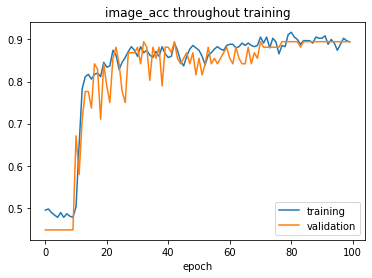

In [28]:
# summarize history for image accuracy
metric = "image_acc"
plt.plot(history.history[metric], label='training')
plt.plot(history.history[f'val_{metric}'], label='validation')
plt.title(f'{metric} throughout training')
#plt.ylabel('Image Accuracy (plume or no plume in image)')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [2]:
MODEL_NAME = "satview_7kmVCD_HeavyAug_drop0.2_100eps_state=43_LRdecay0.1startingatepoch60"
base_metrics = [SparseCategoricalAccuracy()]
model.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=base_metrics, run_eagerly=False)
model.save(f"u-net/{MODEL_NAME}")
#also save history
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history_df.index
history_df.to_csv(f"{MODEL_NAME}_history.csv")

2023-07-16 21:08:46.203822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'model' is not defined

In [5]:
#load model
model = tf.keras.models.load_model("u-net/satview_7kmVCD_HeavyAug_drop0.2_100eps_state=43_LRdecay0.1startingatepoch60")

350 background areas found
360 Plumes found


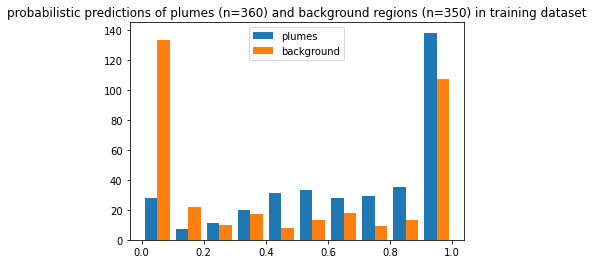

[0.33]
0.6620656830080913


Text(0, 0.5, 'Macro F1-Score')

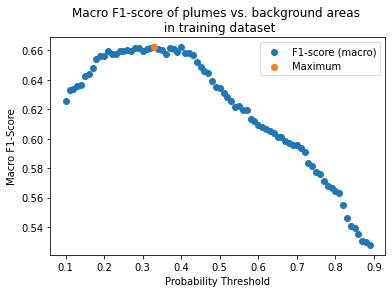

In [120]:
from skimage.measure import label

def separate_masks(binary_mask):
    binary_mask = np.array(binary_mask)
    # Apply connected component labeling
    labeled_mask = label(binary_mask)
    
    # Get the number of distinct regions
    num_regions = np.max(labeled_mask)
    
    # Create a list to store individual masks
    masks = []
    
    # Iterate over each region and extract its mask
    for region_label in range(1, num_regions + 1):
        region_mask = np.zeros_like(binary_mask, dtype=np.uint8)
        region_mask[labeled_mask == region_label] = 1
        masks.append(region_mask)
    
    return masks



ds = train_basic_ds #val_prefetch #test_dataset #val_prefetch

#test_preds = model.predict(ds)  #val_prefetch)

max_plume_probs = []
max_bg_probs = []
for (img,mask), pred in zip(ds.unbatch(), test_preds):
    mask = np.array(mask)
    pred = np.array(pred)
    
    plume_masks = separate_masks(mask)
    background_idx = np.where(plume == False)
    bg_prob = np.max( pred[...,1:][background_idx] )
    max_bg_probs.append(bg_prob)
    
    for plume in plume_masks:
        #fig, axs = plt.subplots(ncols=3)
        #axs[0].imshow(img)
        #axs[1].imshow(plume)
        #axs[2].imshow(pred[...,1])
        
        plume_idx = np.where(plume == True)
        max_prob = np.max( pred[...,1:][plume_idx] )
        #print(bg_prob)
        #print(max_prob)
        
        #breakmeee()
        
        
        
        max_plume_probs.append(max_prob)

#now, plot histogram of max probs
print(f"{len(max_bg_probs)} background areas found")
print(f"{len(max_plume_probs)} Plumes found")
plt.hist([max_plume_probs, max_bg_probs], range=(0,1), bins=10, label=['plumes','background'])
plt.legend()
plt.title("probabilistic predictions of plumes (n=360) and background regions (n=350) in training dataset")
plt.show()
plt.close()


#now, optimize the max probs by F1 score:
#before optimizing, drop values from max_bg_probs that are greater than 0.9, these are almost definitely true positives..
#bg_probs = [val for val in max_bg_probs if val<0.1 ]
from sklearn.metrics import precision_score, recall_score
bg_probs = max_bg_probs
#print(len(bg_probs))
y_true = np.concatenate( ( np.zeros(len(bg_probs)), np.ones(len(max_plume_probs)) ) )
all_probs = np.concatenate( (bg_probs, max_plume_probs) )
                   
#print(y_true)
#print(y_pred)

f1s = []
accs = []
prec = []
rec = []
x_range = np.arange(0.1, 0.9, step=0.01)

for HIGH in x_range:
    y_pred = all_probs > HIGH
    #print(y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    accs.append(acc)
    f1s.append(f1)
    prec.append(precision_score(y_true, y_pred))
    rec.append(recall_score(y_true, y_pred))
                
    

plt.scatter(x_range, f1s, label='Macro F1-score training data (auto)')

print(x_range[np.where(f1s>=np.max(f1s))])
#plt.scatter(0.33, np.max(f1s), label="Maximum")
plt.legend()
print(np.max(f1s))
#plt.title("Macro F1-score of plumes vs. background areas \n in training dataset")
plt.xlabel("Probability Threshold")
plt.ylabel("Macro F1-Score")

Text(0.5, 1.0, 'Plumewise F1-score at different thresholds, validation dataset')

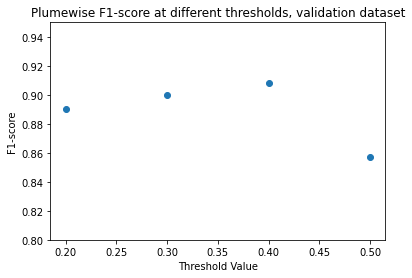

In [23]:
tp_fn_fp = {'0.5':(69, 19, 4), '0.4':(79, 11, 5), '0.3':(81, 9, 9), '0.2':(85, 3, 18) }

f1_scores = {threshold: tp / (tp + 0.5 * (fn + fp)) for threshold, (tp, fn, fp) in tp_fn_fp.items()}

plt.scatter([0.5, 0.4, 0.3, 0.2], f1_scores.values())
plt.ylim([0.8, 0.95])
plt.xlabel('Threshold Value')
plt.ylabel('F1-score')
plt.title('Plumewise F1-score at different thresholds, validation dataset')

38/38 [==============================] - 3s 80ms/step
     LOW  HIGH       IoU
19  0.29   0.4  0.639719


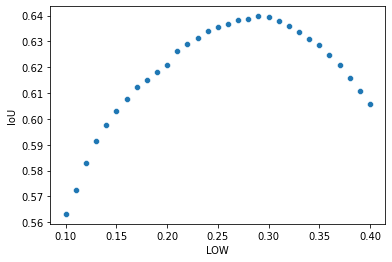

In [26]:
def class_from_mask(mask):
    try: return tf.reduce_max(mask)
    except: return tf.reduce_max(tf.cast(mask,'int'))

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

ds = val_prefetch #test_dataset #

test_preds = model.predict(ds)  #val_prefetch)

masks = [mask for img,mask in ds.unbatch()]
y_true = [class_from_mask(mask) for mask in masks]
y_pred1 = [class_from_mask(pred) for pred in tf.argmax(test_preds, axis=3)]

# Create an empty list to store the data frames
iou = IoU(num_classes=2, target_class_ids=[1], name="IoU")

grid_search_list = []

for HIGH in [0.3]:
    for LOW in np.arange(0.1, 0.4, step=0.01):
        if LOW > HIGH:
            df2 = pd.DataFrame({"LOW": LOW, "HIGH": HIGH, "IoU": np.nan}, index=[0])
        else:
            hyst_preds = np.squeeze([apply_hysteresis_threshold(pred[...,-1], LOW, HIGH) for pred in test_preds]).astype('int')                                                                                                          
            iou.update_state(masks, hyst_preds)
            iou_score = iou.result().numpy()
            #print(iou_score)
            y_pred = [class_from_mask(pred) for pred in hyst_preds]
            acc = accuracy_score(y_true, y_pred) #from sklearn
            #print(f"{HIGH}:sdfds {acc}")
            df2 = pd.DataFrame({"LOW": LOW, "HIGH": HIGH, "IoU": iou_score}, index=[0])
            iou.reset_states()
        grid_search_list.append(df2)

# Concatenate the list of data frames into a single data frame
grid_search = pd.concat(grid_search_list, ignore_index=True)

# Plot the scatterplot
sns.scatterplot(data=grid_search, x="LOW", y="IoU")
print(grid_search.loc[grid_search.IoU == grid_search.IoU.max()])

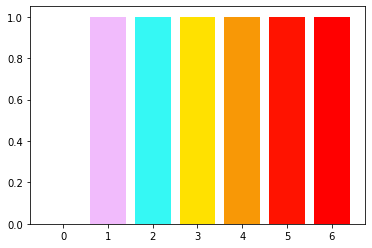

In [8]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

color_stops = [0, .05, .1, .175, .25, .99, 1]
colors = [(255, 255, 255),
          (241, 187, 252),
          (53, 248, 244),
          (255, 225, 0),
          (248, 152, 6),
          (255, 19, 0),
          (255, 0, 0)]
norm_colors = [(R/255,G/255,B/255) for (R,G,B) in colors]
cmap_segments = list(zip(color_stops, norm_colors))
cmap2 = LinearSegmentedColormap.from_list('so2_cmap', cmap_segments, N=256)
mpl.colormaps.register(cmap2)
DU = img*2241.15
#plt.imshow(DU, cmap=cmap2, vmin=0, vmax=20)
#plt.colorbar()

for x, col in enumerate(norm_colors):
    plt.bar(x, 1, color=col)

In [10]:
#test_preds = model.predict(val_prefetch)
#If I could write a function to identify unique plumes?
#Get maximum probability of each plume in the validation dataset

from sklearn.metrics import confusion_matrix, classification_report
def class_from_mask(mask):
    return tf.reduce_max(mask)

ds = val_prefetch #test_dataset #

test_preds = model.predict(ds)  #val_prefetch)

y_true = [class_from_mask(mask) for img,mask in ds.unbatch()]
y_pred = [class_from_mask(pred) for pred in tf.argmax(test_preds, axis=3)]
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

x=0
for (img,mask), pred in zip(ds.unbatch(), test_preds):
    x+=1
    #if x!=55:
    #    continue
    fig, axs = plt.subplots(ncols=3, figsize=(17,7))
    fn = fn_val.iloc[x-1]
    #now, reopen the file and convert it to DU
    vcd = np.load(fn)[...,7]
    DU = vcd*2241.15
    #i = axs[0].imshow(img, interpolation='none', origin='lower')
    i = axs[0].imshow(DU, interpolation='none', origin='lower', cmap='so2_cmap', vmin=0, vmax=20)
    m = axs[1].imshow(mask, interpolation='none', origin='lower')
    #m = axs[1].imshow( pred[...,-1] , interpolation='none', vmin=0, vmax=1, origin='lower')
    #hysteresis or static threshold
    p = axs[2].imshow( apply_hysteresis_threshold(pred[...,-1], 0.2, 0.3) , interpolation='none', vmin=0, vmax=1, origin='lower')
    plt.colorbar(i, ax=axs[0], shrink=1, label='Dobson Units', orientation="horizontal", pad=0.05)
    plt.colorbar(m, ax=axs[1], shrink=1, label='Label', orientation="horizontal", pad=0.05)
    plt.colorbar(p, ax=axs[2], shrink=1, label='Probability', orientation="horizontal", pad=0.05)
    axs[0].set_title("7km VCD (DU)")
    axs[1].set_title("Manual Label")
    axs[2].set_title("Hysteresis Thresholded Prediction")
    fig.suptitle(f"{fn}")
    for ax in axs:
        ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    plt.show()
    plt.close()     
     
""" validation dataset:
threshold=0.5
75 images, 88 plumes total. 33 images with no plumes 42 with plumes
69 TP,  19 FN, 4 FP, true negatives = image with no plume pred with no plume
F1-score = 0.85
threshold=05 --> TP=69, FN=19, FP=4
threshold=0.4 --> TP=79, FN=11, FP=5
threshold=0.3 --> TP=81, FN=9, FP=9 F1=0.9
threshold=0.2 --> 85, FN=3, FP= 18



test dataset:
75 images, 84 plumes total. 37 images with no plumes, 38 with plumes
42 TP, 0 FP, 32 FN

threshold = 0.3 --> TP=56, TN=38, FP=5, FN=26


"""

38/38 [==============================] - 15s 383ms/step
              precision    recall  f1-score   support

         0.0       0.82      0.97      0.89        33
         1.0       0.97      0.83      0.90        42

    accuracy                           0.89        75
   macro avg       0.90      0.90      0.89        75
weighted avg       0.91      0.89      0.89        75

[[32  1]
 [ 7 35]]


TypeError: '_UnbatchDataset' object is not subscriptable

In [18]:
for img, mask in ds.unbatch():
    test_img, test_msk = (img, mask)

In [23]:
test_img = tf.reshape(test_img, [1,352,352,1])

1/1 [==============================] - 1s 685ms/step


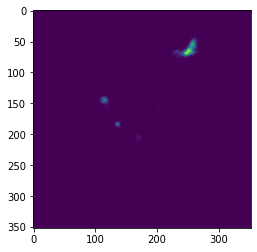

In [27]:
testpred = model.predict(test_img)
plt.imshow(testpred[0,:,:,1])

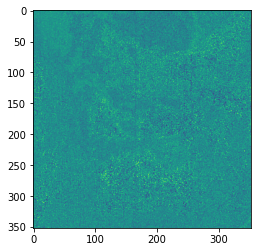

In [26]:
plt.imshow(test_img[0,:,:,0])